In [13]:
import sys
sys.path.append("../")
from dataclasses import dataclass
from typing import Mapping, Dict, Tuple
from rl.distribution import Categorical, FiniteDistribution, Constant
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess, NonTerminal 
import matplotlib.pyplot as plt
import itertools

plt.rcParams['figure.figsize'] = (15, 7)

# Question 1:
The state space is: $S_t = \{1, 2, \cdots, 100\}$ where 100 is the terminal state (we win the game when we reach 100).          
The transition probability matrix is:
$$
\mathcal{P}_{ij} = 
    \begin{cases}
        \frac{1}{6}, & \text{if state} ~ i ~ \text{goes to state} ~ j
        \\ 0, & \text{otherwise}
    \end{cases}
$$
For example, if I were at state 12, then I have 6 different possibilities for the next state: 13, 14, 15, 16, 17, 18, or 19. If a ladder exists from 16 to 32, then $\mathcal{P}_{12, 32} = \frac{1}{6}$ and $\mathcal{P}_{12, 16} = 0$ instead. We consider the case of a snake in a similar manner, except that here $i > j$.            
# Question 2

In [14]:
@dataclass(frozen=True)
class State:
	position : int 



class SnakesAndLaddersMP(FiniteMarkovProcess[State]):
	def __init__(self, from_to : Mapping[State, State]):
		'''
        @from_to lists the ladders and the snakes. 
        For example, if there was a ladder from state 43 to state 87,
        then this would be represented in the dictionary as:
        {State(position = 43) : State(position - 87)}, and so on.
        '''
		self.from_to = from_to
		super().__init__(self.get_transition_map())


	def get_transition_map(self) -> Mapping[State, FiniteDistribution[State]]:
		d : Dict[State, FiniteDistribution[State]] = {}

		for state in range(1, 100):
			state_probs_map = {}
			next_state = 0
			
			for j in range(state + 1, min(101, state + 7)):
				if j in self.from_to.keys():
					next_state = self.from_to[j]
				else:
					next_state = j

				state_probs_map[State(position = next_state)] = 1. / 6.

            # If I'm at state 97, I need only a 3 to reach 100.
            # If I get more than a 3, I stay in the same position.
			if state > 94:
				state_probs_map[State(position = state)] = (state - 94.) / 6.

			d[State(position = state)] = Categorical(state_probs_map)

		return d

### Create an instance of the Snakes and Ladders game

In [15]:
changes_from = [1, 4, 9, 28, 36, 21, 51, 71, 80, 16, 47, 49, 56, 64, 87, 93, 95, 98]
changes_to = [38, 14, 31, 84, 44, 42, 67, 91, 100, 6, 26, 11, 53, 60, 24, 73, 75, 78]

from_to = {fr : to for fr, to in zip(changes_from, changes_to)}
game = SnakesAndLaddersMP(from_to = from_to)

# print("Transition Map")
# print("----------------")
# print(game)

### Generate the constant distribution of the starting states and generate traces of the game and count the total number of dice rolls needed per game to finish it

In [16]:
start_distribution = Constant(value = NonTerminal(State(position = 1)))
num_traces = 10000

outcomes = [len([st for st in it]) for it in itertools.islice(game.traces(start_distribution), num_traces)]

### Plot the histogram of the time steps (number of dice rolls)

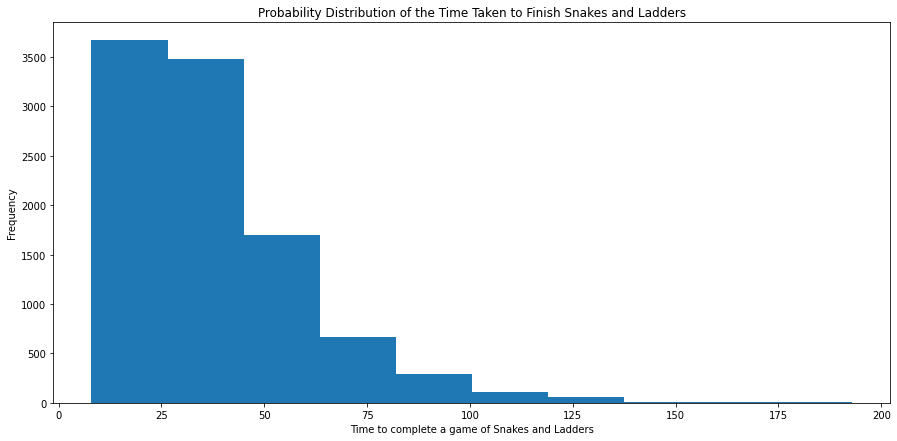

In [17]:
plt.hist(outcomes)

plt.xlabel('Time to complete a game of Snakes and Ladders')
plt.ylabel('Frequency')
plt.title("Probability Distribution of the Time Taken to Finish Snakes and Ladders")
plt.show()

# Question 3

In [18]:
@dataclass(frozen=True)
class State:
	position : int


class FrogPuzzle(FiniteMarkovProcess[State]):
	length : int = 0 # this is the length of the river between the two banks

	def __init__(self, length : int):
		self.length = length
		super().__init__(self.get_transition_map())

	def get_transition_map(self) -> Mapping[State, FiniteDistribution[State]]:
		d : Dict[State, FiniteDistribution[State]] = {}

		for state in range(1, self.length + 2):
			state_prob_map = {}
			for next_state in range(state + 1, self.length + 3):
				state_prob_map[State(position=next_state)] = 1. / (self.length - state + 2)

			d[State(position = state)] = Categorical(state_prob_map)

		return d

### Create an instance of the Markov process

In [19]:
L = 20

puzzle = FrogPuzzle(L)
# print("Transition Map")
# print("----------------")
# print(puzzle)

### Generate traces of it and get the total number of jumps required to get to the other side of the river

In [20]:
start_distribution = Constant(value = NonTerminal(State(position = 1)))
num_traces = 10000

outcomes = [len([i for i in trace]) for trace in itertools.islice(puzzle.traces(start_distribution), num_traces)]

### Plot a histogram of the jumps required to get to the other side of the river

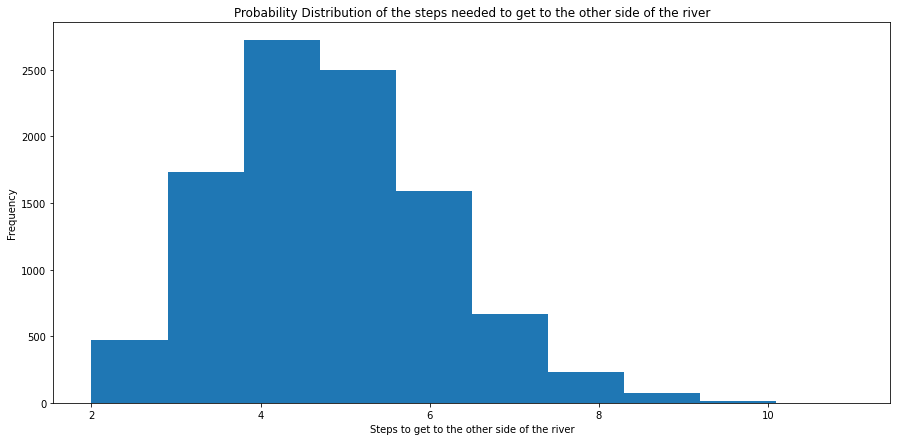

In [21]:
plt.hist(outcomes)

plt.xlabel('Steps to get to the other side of the river')
plt.ylabel('Frequency')
plt.title("Probability Distribution of the steps needed to get to the other side of the river")
plt.show()

# Question 4
Here I recreate the Snakes and Ladders game, but with rewards associated with each state. In order to find the expected number of dice rolls to finish a game, I set the rewards of all states to 1.

In [22]:
@dataclass(frozen=True)
class State:
	position : int 

class SnakesAndLaddersMRP(FiniteMarkovRewardProcess[State]):
	def __init__(self, from_to : Mapping[State, State]):
		self.from_to = from_to
		super().__init__(self.get_transition_reward_map())

	def get_transition_reward_map(self) -> Mapping[State, FiniteDistribution[Tuple[State, float]]]:
		d : Dict[State, FiniteDistribution[Tuple[State, float]]] = {}
		reward = 1

		for state in range(1, 100):
			state_probs_map = {}
			next_state = 0
			
			for j in range(state + 1, min(101, state + 7)):
				if j in self.from_to.keys():
					next_state = self.from_to[j]
				else:
					next_state = j

				state_probs_map[(State(position = next_state), reward)] = 1. / 6.

			if state > 94:
				state_probs_map[(State(position = state), reward)] = (state - 94.) / 6.

			d[State(position = state)] = Categorical(state_probs_map)

		return d

### Create an instance of the game

In [23]:
changes_from = [1, 4, 9, 28, 36, 21, 51, 71, 80, \
                16, 47, 49, 56, 64, 87, 93, 95, 98]
changes_to = [38, 14, 31, 84, 44, 42, 67, 91, 100, \
                6, 26, 11, 53, 60, 24, 73, 75, 78]

from_to = {fr : to for fr, to in zip(changes_from, changes_to)}
game = SnakesAndLaddersMRP(from_to = from_to)
gamma = 1.0 # the discount factor

# print("Transition Map")
# print("--------------")
# print(FiniteMarkovProcess({s.state: Categorical({s1.state: p for s1, p in v.table().items()}) \
#                                     for s, v in game.transition_map.items()}))

# print()
# print("Transition Reward Map")
# print("----------------")
# print(game)

# print()
# print("Reward Function")
# print("----------------")
# game.display_reward_function()

# print()
# print("Value Function")
# print("----------------")
# game.display_value_function(gamma = gamma)

### Use Monte Carlo simulations to find the expected number of dice rolls to win the game and compare this with the value obtained using Markov reward processes:

In [24]:
val = game.get_value_function_vec(gamma = gamma)
print(f"The expected number of dice rolls (using the value function) is {val[0]:.3f}.")

start_distribution = Constant(value = NonTerminal(State(position = 1)))
num_traces = 10000
outcomes = [len([st for st in it]) for it in itertools.islice(game.reward_traces(start_distribution), num_traces)]
print(f"The expected number of dice rolls (using Monte Carlo)        is {sum(outcomes) / num_traces:.3f}.")

The expected number of dice rolls (using the value function) is 36.819.
The expected number of dice rolls (using Monte Carlo)        is 36.787.
